## Video Analytics

Analyzing video based content requires transforming from one media format (video or audio) to another format (text or numeric) while identifying relevant structure in the resulting format. This multi-media transformation requires machine learning based recognition. Analytics libraries can work on the transformed data to determine the required outcomes including visualizations and charts. The structured data in text or numeric format can also be reused as input to training new machine learning models.

In this notebook we build a simple API to display video in-place from Amazon S3 source, detect text labels based on video contents or visuals, analyze these detected labels by creating a word cloud, and search these labels matching specific text. This API can be used to build video search and analytics solutions. A potential use case is within learning management systems where the detected video labels can be used within a text based search engine to search not only among multiple videos but also within a video by matching the frame timestamp with a label. Video labels word cloud or label distribution can help analyze and visualize video content semantics in code.

Python libraries we will use include AWS SDK for Python (Boto3) to call AWS services. We will use ``pandas`` for analyzing label results as DataFrames. IPython library will provide display functionality. The ``time`` and ``io`` libraries provide utility functions used by our API. Word Cloud visualization is provided by the ``wordcloud`` library and ``matplotlib`` is the popular Python visualization library used in this notebook.

In [1]:
import boto3
import pandas as pd
import numpy as np
from IPython.display import display, Markdown, HTML
import time
import io
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Amazon Rekognition provides capabilities to recognize content within still imagery as well as motion video. To use the Rekognition API with Boto3 SDK we initialize the ``rek`` client.

In [2]:
rek = boto3.client('rekognition')

### Show Video
We define our first API function for video analytics for showing video in-place within this notebook from Amazon S3 source. We can pass parameters to turn on/off autoplay and player controls. We can also specify the %size of the video to display.

In [3]:
def show_video(bucket, key, size=100, autoplay=False, controls=True):
    source = f'https://s3.amazonaws.com/{bucket}/{key}'
    html = '''
    <div align="middle">
        <video width="{}%"{}{}>
          <source src="{}" type="video/mp4">
        </video>
    </div>
    '''
    html = html.format(size, 
                       ' controls' if controls else '', 
                       ' autoplay' if autoplay else '', 
                       source)
    return HTML(html)

We are specifying the S3 bucket where stored video is present and the key representing the path to the video file. You may want to replace these values with your own stored video on S3.

In [4]:
bucket='cloudstory'
key='notebooks-media/alexa-for-business-people.mp4'

show_video(bucket, key)

### Video Labels Job
We can now define an API function for starting label recognition job on the S3 stored video. Label detection runs a machine learning model developed by AWS to process the video imagery detencting objects in the video and identifying these by label names coordinated with video frame timestamp. We do not need to perform any model training or deployment. The function takes S3 location as input and returns a Job ID of the label detection job in progress.

In [5]:
def video_labels_job(bucket, key):
    video = {'S3Object': {'Bucket': bucket, 'Name': key}}
    response_detect = rek.start_label_detection(Video = video)
    return response_detect['JobId']

In [6]:
jobId = video_labels_job(bucket, key)
jobId

'e16110ea93a00db65a0a6a7b92e7eabcdc1d902841ee5fc77656283e457594e6'

### Video Labels Result
Depending on the length and resolution of the video the Rekognition label detection job may take several seconds to a few minutes. We will define a function to wait for this job to complete. Once the job is complete, we will publish video duration in milliseconds and framerate identified by the label detection job. We will then go on to read the response from label detection job, paginating results if these are greater than 1000 labels detected. We will then process the response and convert the resulting JSON representation into a ``pandas`` DataFrame, making the data available for analytics.

In [7]:
def video_labels_result(jobId):
    display('In Progress...')
    response_label = rek.get_label_detection(JobId=jobId)
    while response_label['JobStatus'] == 'IN_PROGRESS':
        time.sleep(5)
        response_label = rek.get_label_detection(JobId=jobId)

    display('Getting Labels...')
    display(f"Video Duration (ms): {response_label['VideoMetadata']['DurationMillis']}")
    display(f"FrameRate: {int(response_label['VideoMetadata']['FrameRate'])}")

    labels = []
    while response_label:
        labels.extend(response_label['Labels'])
        if 'NextToken' in response_label:
            response_label = rek.get_label_detection(JobId=jobId, NextToken=response_label['NextToken']) 
        else:
            response_label = None
    
    display(f'Succeeded in detecting {len(labels)} labels.')
    
    df = pd.DataFrame(labels)
    df['LabelName'] = df['Label'].apply(lambda x: x['Name'])
    df['Score'] = df['Label'].apply(lambda x: round(float(x['Confidence']), 2))
    df['Instances'] = df['Label'].apply(lambda x: len(x['Instances']) if x['Instances'] else 0)
    df['ParentsCount'] = df['Label'].apply(lambda x: len(x['Parents']))
    df['Parents'] = df['Label'].apply(lambda x: ', '.join(map(lambda x : x['Name'], x['Parents'])))
    df = df.drop(columns=['Label'])
    return df    

The sample video we analyzed for this notebook returns 1,256 labels. Each detected label is matched with a timestamp within the video. We also get confidence score from the Rekognition model. Higher confidence generally means more accurate model results. We get insights on number of instances of a particular label or object within a frame at a particular timestamp. So if there are three people in a frame, instance count for ``Person`` label maybe three. We also get ``Parents`` or synonyms for the labels detected.

In [8]:
df = video_labels_result(jobId)
df.head(10)

'In Progress...'

'Getting Labels...'

'Video Duration (ms): 11345'

'FrameRate: 23'

'Succeeded in detecting 1256 labels.'

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
0,0,Apparel,66.54,0,0,
1,0,Audience,50.53,0,2,"Person, Crowd"
2,0,Building,60.53,0,0,
3,0,Clothing,66.54,0,0,
4,0,Coat,66.54,0,1,Clothing
5,0,Computer,82.03,0,1,Electronics
6,0,Conference Room,86.87,0,2,"Room, Indoors"
7,0,Crowd,54.35,0,1,Person
8,0,Electronics,82.03,0,0,
9,0,Furniture,76.07,0,0,


### Video Labels Text
Before we run further analytics on the detected labels, we need a way to query all the labels found. The ``video_labels_text`` function returns a string of all such labels.

In [9]:
def video_labels_text(df):
    si = io.StringIO()
    df['LabelName'].apply(lambda x: si.write(str(x + ' ')))
    s = si.getvalue()
    si.close()
    return s

In [10]:
text = video_labels_text(df)
text[500:1000]

'nce Room Crowd Electronics Furniture Hardware Human Indoors Interview Meeting Room Mouse Office Office Building Overcoat People Person Room Sitting Speech Suit Table Apparel Audience Building Clothing Coat Computer Conference Room Crowd Electronics Furniture Hardware Human Indoors Interview Meeting Room Mouse Office Office Building Overcoat People Person Room Sitting Speech Suit Table Apparel Audience Building Clothing Coat Computer Conference Room Crowd Electronics Furniture Hardware Human Indo'

### Video Labels Wordcloud
You will notice that many labels repeat. If we want to understand the distribution of these labels, we can simply visualize a Word Cloud based on frequency of these labels.

In [11]:
def video_labels_wordcloud(text):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(width = 600, height = 300, background_color = 'black', max_words = len(text),
                          max_font_size = 30, relative_scaling = .5, colormap = 'Spectral').generate(text)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()

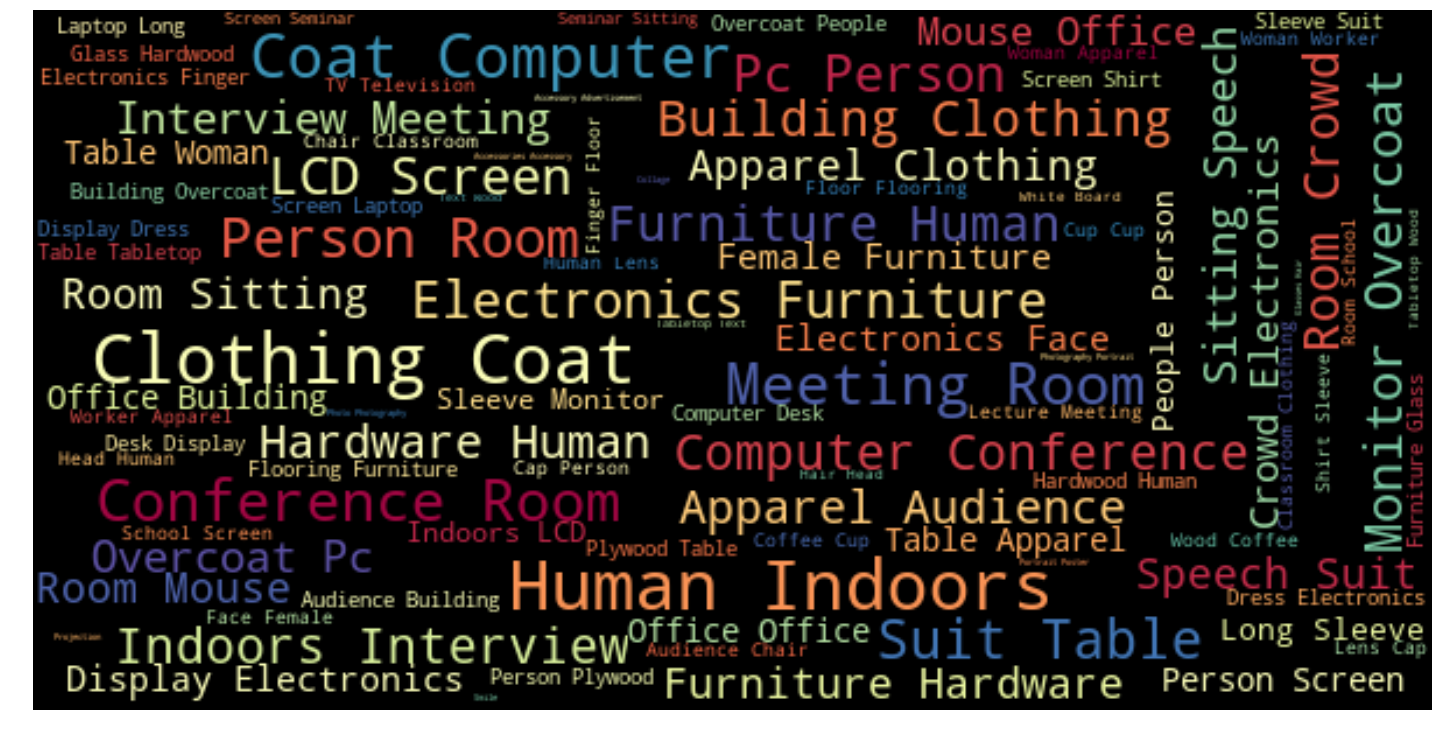

In [12]:
video_labels_wordcloud(text)

### Video Labels Search
Now we are ready to search the labels to programmatically analyze the semantics or content of the video. The ``video_labels_search`` API matches a column within the results DataFrame with a matching string contained within the values of that column.

In [13]:
def video_labels_search(df, column, match):
    df_result = df[df[column].str.contains(match)]
    return df_result

If we match ``Person`` within ``LabelName`` column we can analyze how many people feature in the video at various points in the video. You can use this API in use cases like attendance monitoring for conference rooms, training sessions, or even polling booths.

In [14]:
video_labels_search(df, 'LabelName', 'Person')

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
20,0,Person,99.76,4,0,
46,166,Person,99.76,4,0,
72,375,Person,99.76,4,0,
98,583,Person,99.76,4,0,
125,792,Person,99.77,4,0,
151,959,Person,99.77,4,0,
176,1167,Person,99.77,4,0,
198,1376,Person,99.73,4,0,
215,1584,Person,99.69,4,0,
228,1793,Person,99.65,2,0,


We can also match ``Parents`` or synonyms of the labels detected to understand the semantics or content of the video using code. The sample video as this search suggests contains several objects under the general category of ``Computer`` which implies an office setting where the video is shot.

In [15]:
video_labels_search(df, 'Parents', 'Computer')

,Timestamp,LabelName,Score,Instances,ParentsCount,Parents
15,0,Mouse,82.03,1,3,"Computer, Electronics, Hardware"
41,166,Mouse,83.93,1,3,"Electronics, Hardware, Computer"
67,375,Mouse,85.22,1,3,"Computer, Hardware, Electronics"
93,583,Mouse,87.57,1,3,"Hardware, Electronics, Computer"
119,792,Mouse,89.41,1,3,"Electronics, Hardware, Computer"
123,792,Pc,50.10,0,2,"Electronics, Computer"
146,959,Mouse,89.70,1,3,"Computer, Hardware, Electronics"
172,1167,Mouse,90.15,1,3,"Computer, Electronics, Hardware"
195,1376,Mouse,73.25,1,3,"Electronics, Computer, Hardware"
214,1584,Mouse,55.04,1,3,"Computer, Electronics, Hardware"


### Video Label Stats
For use cases where you want to count the number of objects in the video we can build the ``video_label_stats`` function which searches for a specific label and returns statistics for that label.

In [16]:
def video_label_stats(df, label):
    df_stats = video_labels_search(df, column='LabelName', match=label)
    print(f'Displaying stats on number of instances for label "{label}"')
    return df_stats.describe()

The stats for this video and ``Person`` label suggest that at max 12 people appeared at the same time during the video, at least two people were present throughout the video, with three to four people during most of the video. If this video is monitoring utilization of an office conference room, the analytics results can help determine optimal room seating, calendar scheduling, air conditioning, and other facilities related decisions, when analyzed over a period of usage. The score stats suggest that the label was detected with 99% confidence in most cases.

In [17]:
video_label_stats(df, 'Person')

Displaying stats on number of instances for label "Person"


,Timestamp,Score,Instances,ParentsCount
count,55.000000,55.000000,55.000000,55.0
mean,5633.072727,97.434545,4.145455,0.0
std,3366.954899,8.072887,2.197795,0.0
min,0.000000,60.300000,2.000000,0.0
25%,2689.500000,99.250000,3.000000,0.0
50%,5797.000000,99.690000,4.000000,0.0
75%,8487.000000,99.770000,4.000000,0.0
max,11177.000000,99.870000,12.000000,0.0


### Video Persons Job
We will now solve for the People Pathing problem. Amazon Rekognition can track the path people take within a video and identify the location of a person within a video frame. Use cases can include analyzing sports person performance or learning a dance step. Let's start by creating a function to submit person tracking job to Rekognition.

In [18]:
def video_persons_job(bucket, key):
    video = {'S3Object': {'Bucket': bucket, 'Name': key}}
    response_detect = rek.start_person_tracking(Video = video)
    return response_detect['JobId']

In [19]:
personsJobId = video_persons_job(bucket, key)
personsJobId

'a537769e31e94d714720b956fda3a0176d6130817208134a8f2269f48ac0ba21'

### Video Persons Result
This function gets the results from person tracking job submitted earlier. It loops to check job status as it changes from ``IN_PROGRESS`` state. Then it provides some basic information about the video being analyzed like the frame rate or the duration. This is followed by creating a list of paths taken by the persons within the video. We return a DataFrame with persons identified as an index starting from zero, the timestamp of the video frame where the person is present, and the bounding box left, top, height, and width dimensions for the person identified.

In [20]:
def video_persons_result(jobId):
    display('In Progress...')
    response_person = rek.get_person_tracking(JobId=jobId)
    while response_person['JobStatus'] == 'IN_PROGRESS':
        time.sleep(5)
        response_label = rek.get_person_tracking(JobId=jobId)

    display('Getting Person Paths...')
    display(f"Video Codec: {response_person['VideoMetadata']['Codec']}")
    display(f"Video Duration (ms): {str(response_person['VideoMetadata']['DurationMillis'])}")
    display(f"Video Format: {response_person['VideoMetadata']['Format']}")
    display(f"Video FrameRate: {int(response_person['VideoMetadata']['FrameRate'])}")

    persons = []
    while response_person:
        persons.extend(response_person['Persons'])
        if 'NextToken' in response_person:
            response_person = rek.get_person_tracking(JobId=jobId, NextToken=response_person['NextToken']) 
        else:
            response_person = None
    
    display(f'Succeeded in detecting {len(persons)} person paths.')
    
    df = pd.DataFrame(persons)
    df['Left'] = df['Person'].apply(lambda x: round(x['BoundingBox']['Left'], 2) if 'BoundingBox' in x else '')
    df['Top'] = df['Person'].apply(lambda x: round(x['BoundingBox']['Top'], 2) if 'BoundingBox' in x else '')
    df['Height'] = df['Person'].apply(lambda x: round(x['BoundingBox']['Height'], 2) if 'BoundingBox' in x else '')
    df['Width'] = df['Person'].apply(lambda x: round(x['BoundingBox']['Width'], 2) if 'BoundingBox' in x else '')
    df['Index'] = df['Person'].apply(lambda x: x['Index'])
    df = df.drop(columns=['Person'])

    return df

In [21]:
show_video(bucket, key, 50)

In [23]:
df_persons = video_persons_result(personsJobId)
df_persons.head(10)

'In Progress...'

'Getting Person Paths...'

'Video Codec: h264'

'Video Duration (ms): 11345'

'Video Format: QuickTime / MOV'

'Video FrameRate: 23'

'Succeeded in detecting 633 person paths.'

,Timestamp,Left,Top,Height,Width,Index
0,0,0.19,0.33,0.42,0.19,0
1,0,0.67,0.37,0.36,0.19,1
2,0,0.42,0.38,0.38,0.19,2
3,0,0,0.29,0.69,0.26,3
4,41,0.19,0.33,0.42,0.19,0
5,41,0.67,0.37,0.36,0.19,1
6,41,0.42,0.38,0.38,0.19,2
7,41,0,0.28,0.69,0.26,3
8,125,0.19,0.33,0.42,0.19,0
9,125,0.67,0.37,0.35,0.2,1


### Video Person Path
This function returns the paths matching a person identified by an index. In this specific example we are searching for the lady sitting in the center of the table as the video begins. Note how the timestamp shows her presence in the video during first 2 seconds of the video, then reappearance around between the 6 and 8 seconds timeframe. Also note how the top and left attributes do not change for the bounding box indicating the lady does not appear to move within the video.

In [24]:
def video_person_path(df, person):
    df_result = df[df['Index'] == person]
    return df_result

In [25]:
video_person_path(df_persons, 1)

,Timestamp,Left,Top,Height,Width,Index
1,0,0.67,0.37,0.36,0.19,1
5,41,0.67,0.37,0.36,0.19,1
9,125,0.67,0.37,0.35,0.2,1
13,166,0.67,0.37,0.35,0.2,1
17,250,0.67,0.37,0.35,0.2,1
21,291,0.67,0.37,0.35,0.2,1
25,375,0.67,0.37,0.35,0.2,1
29,458,0.67,0.37,0.35,0.2,1
33,500,0.67,0.37,0.35,0.2,1
37,583,0.67,0.37,0.35,0.2,1


### Video Person Timeframe
We now write a function to return persons found within a given timeframe of the video. In this example, notice how the person identified by the index 16 is "taller" than the other to persons within the frame. Around the 7 seconds timestamp, the lady in purple dress is standing while the other two persons in the room are seated at the table. The top and left values also change slightly between the two appearances of the lady within the video indicating slight movement.

In [26]:
def video_person_timeframe(df, start, end):
    df_result = df[(df['Timestamp'] >= start) & (df['Timestamp'] <= end)]
    return df_result

In [27]:
video_person_timeframe(df_persons, 7900, 9000)

,Timestamp,Left,Top,Height,Width,Index
409,7924,0.46,0.17,0.76,0.22,14
410,7924,0,0.24,0.71,0.26,15
411,7924,0.68,0.06,0.94,0.32,16
412,7966,0.45,0.16,0.77,0.22,14
413,7966,0,0.24,0.71,0.26,15
414,7966,0.68,0.06,0.94,0.31,16
415,8049,0.44,0.17,0.76,0.2,14
416,8049,0,0.25,0.71,0.26,15
417,8049,0.68,0.06,0.94,0.32,16
418,8133,0.43,0.17,0.76,0.19,14


### Video Persons Frequency
Now we are writing a simple function to indicate how frequently a person identified by an index appears during the entire video. In this example, the three persons sitting on the table facing the camera appear for during most of the video. One also notes that the API recognizes 22 persons during the course of the video. One may want to cross verify this result with the video and the label detection output which identifies 12 persons at max within a frame.

In [28]:
def video_persons_frequency(df):
    return df.groupby('Index')['Timestamp'].nunique()

In [29]:
video_persons_frequency(df_persons)

Index
0     50
1     50
2     50
3     25
4     34
5     34
6     29
7     25
8     23
9     28
10    20
11    23
12     6
13    25
14    36
15    33
16    16
17    23
18    18
19    23
20    23
21    23
22    16
Name: Timestamp, dtype: int64